In [1]:
import pyro
import math
import torch
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import ExitStack
from functools import partial
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

from causal_pyro.dynamical.handlers import (
    PointIntervention,
    DynamicIntervention,
    SimulatorEventLoop,
    simulate,
    ODEDynamics
)

from causal_pyro.dynamical.handlers import NonInterruptingPointObservation as PointObservation

from causal_pyro.dynamical.ops import State

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

In [2]:
# THIS WILL BE REPLACED
from typing import  Dict
from pyro.poutine.runtime import _PYRO_STACK

class TrajectoryObservation(pyro.poutine.messenger.Messenger):
    def __init__(
        self,
        data: Dict[float, Dict[str, torch.Tensor]],
        eps: float = 1e-6,
    ):
        self.observation_managers = []
        for obs_time, obs_state in data.items():
            self.observation_managers.append(PointObservation(obs_time, obs_state, eps=eps))

    def __enter__(self):
        for manager in self.observation_managers:
            manager.__enter__()
        
    def __exit__(self, exc_type, exc_value, traceback):
        for __ in self.observation_managers:
            _PYRO_STACK.pop() # remove the observation manager from the stack (not safe but this handler will be replaced shortly)
            # manager.__exit__(exc_type, exc_value, traceback) # creates an error because last element on stack isn't self



In [3]:
class SimpleSIRDynamics(ODEDynamics):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        dX.S = -self.beta * X.S * X.I
        dX.I = self.beta * X.S * X.I - self.gamma * X.I  # noqa
        dX.R = self.gamma * X.I

    # TODO: the observation model should probably be a truncated poisson. Basically, you systematically undercount the number of infected people
    # and recovered people since not everyone reports 
    def observation(self, X: State[torch.Tensor]):
        test_kit_sales = torch.relu(pyro.sample("test_kit_sales", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample("I_obs", dist.Poisson(X.I)) # noisy number of infected actually observed
        R_obs = pyro.sample("R_obs", dist.Poisson(X.R)) # noisy number of recovered actually observed
        return {"test_kit_sales": test_kit_sales, "I_obs": I_obs, "R_obs": R_obs}

# Generate synthetic data from an SIR model

In [40]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.))
time_period = torch.linspace(0, 3, steps=21)

# We now simulate from the SIR model
beta_true = torch.tensor(0.05)
gamma_true =  torch.tensor(0.5)
sir_true = SimpleSIRDynamics(beta_true, gamma_true)
sir_true_traj = simulate(sir_true, init_state, time_period)

### Plot the simulated trajectories from SIR model

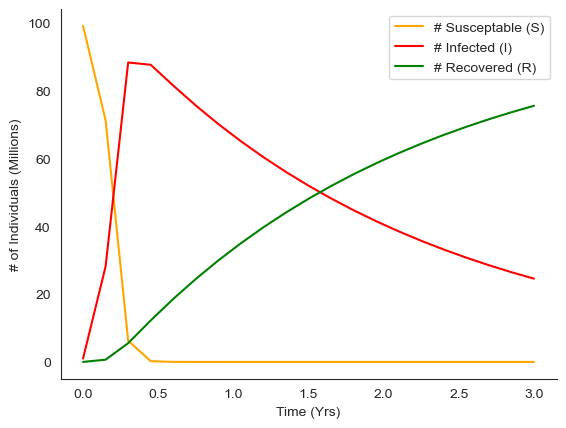

In [39]:
sns.lineplot(x=time_period, y=sir_true_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_true_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_true_traj.R, label="# Recovered (R)", color='green')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")
plt.legend()

### Sample observed data from the model
 

In [6]:
obs_time_period = torch.arange(1/52, .51, 1/52) # collect data every week for the past 6mo
N_obs = obs_time_period.shape[0]
sir_obs_traj = simulate(sir_true, init_state, obs_time_period)
data = dict()
for time_ix in range(N_obs):
    data[obs_time_period[time_ix].item()] = sir_true.observation(sir_obs_traj[time_ix])

In [7]:
test_kit_sales = torch.stack([data[time.item()]["test_kit_sales"] for time in obs_time_period])
I_obs = torch.stack([data[time.item()]["I_obs"] for time in obs_time_period])
R_obs = torch.stack([data[time.item()]["R_obs"] for time in obs_time_period])

Text(0, 0.5, 'Observed # Recovered (Millions)')

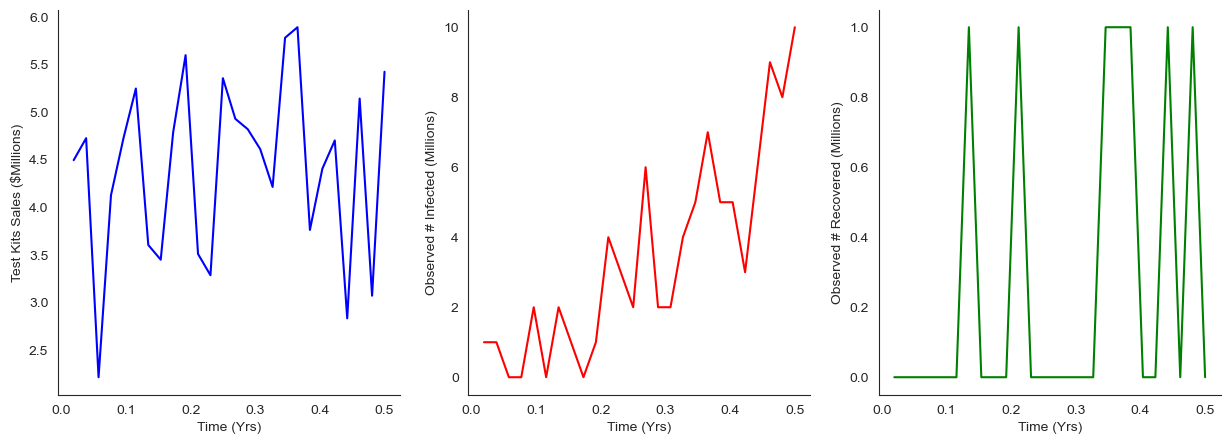

In [8]:
# TODO: actual trend

# Plot observed data
fix, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot test kit sales
sns.lineplot(x=obs_time_period, y=test_kit_sales, color='blue', ax=ax[0])
sns.despine()
ax[0].set_xlabel("Time (Yrs)")
ax[0].set_ylabel("Test Kits Sales ($Millions)")

# Plot observed infected
sns.lineplot(x=obs_time_period, y=I_obs, color='red', ax=ax[1])
sns.despine()
ax[1].set_xlabel("Time (Yrs)")
ax[1].set_ylabel("Observed # Infected (Millions)")

# Plot observed recovered
sns.lineplot(x=obs_time_period, y=R_obs, color='green', ax=ax[2])
sns.despine()
ax[2].set_xlabel("Time (Yrs)")
ax[2].set_ylabel("Observed # Recovered (Millions)")

# Perform Inference!

In [9]:
# We place uniform priors on the beta and gamma parameters defining the SIR model 
def model():
    beta = pyro.sample("beta", dist.Uniform(0, 1))
    gamma = pyro.sample("gamma", dist.Uniform(0, 1))
    sir = SimpleSIRDynamics(beta, gamma)
    return sir


def unconditional_sir_model(data, init_state, tspan):
    sir = model()
    return simulate(sir, init_state, tspan)


def conditioned_sir(data, init_state, tspan):
    sir = model()
    with SimulatorEventLoop():
        with TrajectoryObservation(data):
            traj = simulate(sir, init_state, tspan)
    return traj

In [10]:
guide = AutoMultivariateNormal(conditioned_sir)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(conditioned_sir, guide, adam, loss=Trace_ELBO())
n_steps = 200

# Do gradient steps
pyro.clear_param_store()
for step in range(n_steps):
    loss = svi.step(data, init_state, torch.tensor([0., 3.])) # need tspan to contain all observation times
    print("[iteration %04d] loss: %.4f" % (step + 1, loss / N_obs))
    guide_median = guide.median()
    print("beta post. median est: %.4f, gamma post. median est: %.4f" % (guide_median['beta'].item(), guide_median['gamma'].item()))
        

[iteration 0001] loss: 84.6573
beta post. median est: 0.6580, gamma post. median est: 0.7758
[iteration 0002] loss: 85.9599
beta post. median est: 0.6513, gamma post. median est: 0.7705
[iteration 0003] loss: 85.2382
beta post. median est: 0.6446, gamma post. median est: 0.7652
[iteration 0004] loss: 85.0188
beta post. median est: 0.6377, gamma post. median est: 0.7597
[iteration 0005] loss: 84.8100
beta post. median est: 0.6307, gamma post. median est: 0.7542
[iteration 0006] loss: 83.5493
beta post. median est: 0.6237, gamma post. median est: 0.7487
[iteration 0007] loss: 83.4674
beta post. median est: 0.6165, gamma post. median est: 0.7431
[iteration 0008] loss: 85.0198
beta post. median est: 0.6094, gamma post. median est: 0.7373
[iteration 0009] loss: 83.4924
beta post. median est: 0.6021, gamma post. median est: 0.7316
[iteration 0010] loss: 83.4898
beta post. median est: 0.5948, gamma post. median est: 0.7258
[iteration 0011] loss: 83.8189
beta post. median est: 0.5874, gamma po

# Evaluate the performance of our inference

In [11]:
# Generate samples from the posterior predictive distribution
predictive = Predictive(unconditional_sir_model, guide=guide, num_samples=100)
samples = predictive(data, init_state, torch.tensor([0., .01])) # just trying to get beta and gamma samples

### First, we compare the approximate posterior distribution with the true beta and gamma parameters generating the data

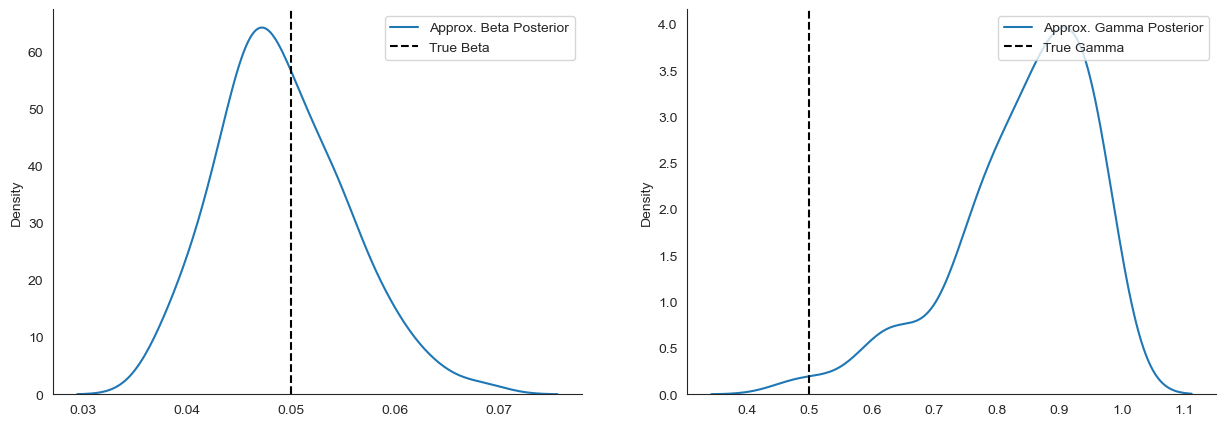

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(samples['beta'], label='Approx. Beta Posterior', ax=ax[0])
ax[0].axvline(beta_true, color='black', label='True Beta', linestyle='--')
sns.despine()
ax[0].legend(loc='upper right')

sns.kdeplot(samples['gamma'], label='Approx. Gamma Posterior', ax=ax[1])
plt.axvline(gamma_true, color='black', label='True Gamma', linestyle='--')
sns.despine()
ax[1].legend(loc='upper right')

### Next, we compare the predictive performance on the held at period between $t=.5$ and $t=3$ years

In [13]:
# TODO: we should add functionality so that pyro Predictive gives use predictions of sites in `observation` method...

S_pred = []
I_pred = []
R_pred = []

for beta, gamma in zip(samples['beta'], samples['gamma']):
    sir = SimpleSIRDynamics(beta, gamma)
    sir_traj = simulate(sir, init_state, time_period)
    S_pred.append(sir_traj.S)
    I_pred.append(sir_traj.I)
    R_pred.append(sir_traj.R)

# Reshape as a tensor of postior samples x time matrix
S_pred = torch.stack(S_pred)
I_pred = torch.stack(I_pred)
R_pred = torch.stack(R_pred)

In [149]:
def SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax):
    sns.lineplot(x=time_period, y=state_pred.mean(dim=0), color=color, label="Posterior Mean", ax=ax)
    ax.fill_between(time_period, state_pred.mean(dim=0) - 2*state_pred.std(dim=0), state_pred.mean(dim=0) + 2*state_pred.std(dim=0), alpha=0.2, color=color)
    ax.set_xlabel("Time (Yrs)")
    ax.set_ylabel(ylabel)

def SIR_data_plot(time_period, data, data_label, ax):
    sns.lineplot(x=time_period, y=data, color='black', ax=ax, linestyle='--', label=data_label)

def SIR_test_plot(test_time, ax):
    ax.axvline(test_time, color='black', linestyle='dotted', label='Start of Testing Period')

def SIR_plot(time_period, test_time, state_pred, data, ylabel, color, data_label, ax):
    SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax)
    SIR_data_plot(time_period, data, data_label, ax)
    SIR_test_plot(test_time, ax)
    ax.legend()
    sns.despine()

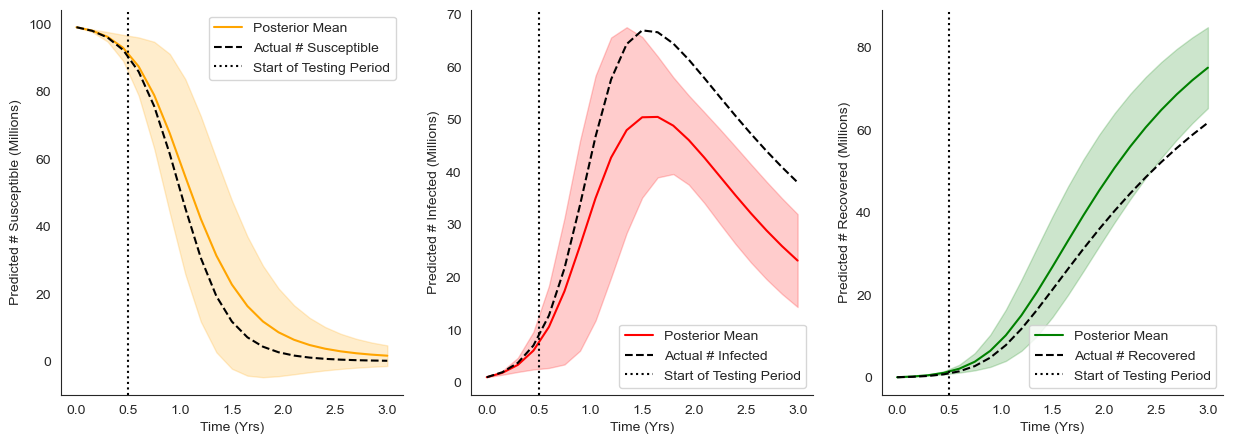

In [154]:
# Plot predicted values for S, I, and R with uncertainty bands (+/- 2 std. devs.)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(time_period, 0.5, S_pred, sir_true_traj.S, "Predicted # Susceptible (Millions)", "orange", "Actual # Susceptible", ax[0])
SIR_plot(time_period, 0.5, I_pred, sir_true_traj.I, "Predicted # Infected (Millions)", "red", "Actual # Infected", ax[1])
SIR_plot(time_period, 0.5, R_pred, sir_true_traj.R, "Predicted # Recovered (Millions)", "green", "Actual # Recovered", ax[2])

## Supppose the healthcare system capacity is only 50 million infected people. Let's explore how different interventions might flatten the infection curve

Suppose the government can enact different lockdown measures (of varying strength) to flatten the infection curve. The goal is the select a lockdown measure so that the number of infected individuals is less than 50 million at any point in time.

Following [2], we define the stength of lockdown measure at time $t$ by $l_t \in [0, 1]$ for $1 \leq t \leq T$. Parametrize the transmission rate $\beta_t$ as:

\begin{equation*}
    \beta_t = (1 - l_t) \beta_0,
\end{equation*}

where $\beta_0$ denotes the unmitigated transmission rate and larger values of $l_t$ correspond to stronger lockdown measures. Then, the time-varying SIR model is defined as follows:

\begin{equation*}
    \begin{split}
        dS_t &= -\beta_t S_t I_t \\
        dI_t &= \beta_t S_t I_t - \gamma I_t \\
        dR_t &= \gamma I_t
    \end{split}
\end{equation*}

where $S_t, I_t, R_t$ denote the number of susceptable, infected, and recovered individuals at time $t$ for $1 \leq t \leq T$.

In [15]:
# TODO: re-write first one so that the class below can just inherit from it
class SimpleSIRDynamicsIntervenable(ODEDynamics):
    def __init__(self, beta0, gamma):
        super().__init__()
        self.beta0 = beta0
        self.gamma = gamma

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        beta_t = (1 - X.l) * self.beta0 # time-varing beta parametrized by lockdown strength l_t
        dX.l = torch.tensor(0.)
        dX.S = -beta_t * X.S * X.I
        dX.I = beta_t * X.S * X.I - self.gamma * X.I  # noqa
        dX.R = self.gamma * X.I

    def observation(self, X: State[torch.Tensor]):
        S = pyro.deterministic("S", X.S)
        I = pyro.deterministic("I", X.I)
        R = pyro.deterministic("R", X.R)
        test_kit_sales = torch.relu(pyro.sample("test_kit_sales", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample("I_obs", dist.Poisson(X.I)) # noisy number of infected actually observed
        R_obs = pyro.sample("R_obs", dist.Poisson(X.R)) # noisy number of recovered actually observed
        return {"test_kit_sales": test_kit_sales, "I_obs": I_obs, "R_obs": R_obs, "S": S, "I": I, "R": R}

init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.), l=torch.tensor(0.))

In [16]:
def intervened_sir(lockdown_policy, init_state, tspan, beta_true=None, gamma_true=None):
    if beta_true is not None and gamma_true is not None:
        sir = SimpleSIRDynamicsIntervenable(beta_true, gamma_true)
    else:
        beta0 = pyro.sample("beta0", dist.Uniform(0, 1))
        gamma = pyro.sample("gamma", dist.Uniform(0, 1))
        sir = SimpleSIRDynamicsIntervenable(beta0, gamma)
    intervene_managers = []
    for time, strength in lockdown_policy.items():
        intervene_managers.append(PointIntervention(time=torch.tensor(time), intervention=State(l=strength)))
    with SimulatorEventLoop():
        with ExitStack() as stack:
            for manager in intervene_managers:
                stack.enter_context(manager)
            traj = simulate(sir, init_state, tspan)
    return traj

### Let's first look at a deterministic intervention where the transmission rate is reduced by 75% between $t=1$ and $t=2$ due to stronger lockdown measures. We see in the figure below that this lockdown measures indeed "flattens" the curve.

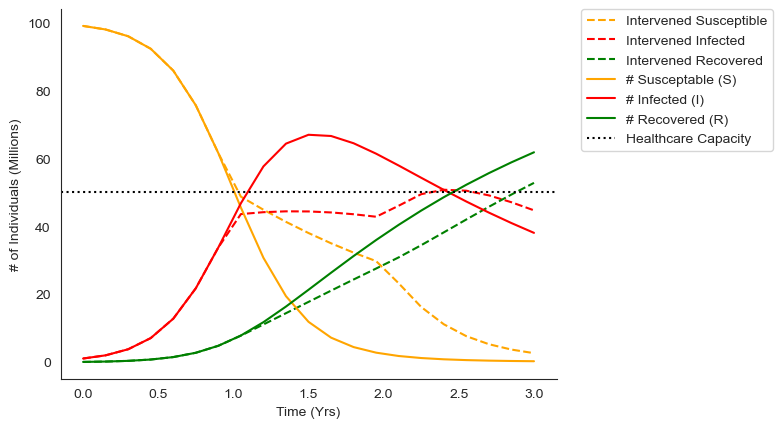

In [17]:
lockdown_policy = dict()
lockdown_policy[1.01] = torch.tensor(.75) 
lockdown_policy[2] = torch.tensor(0.) # no more lockdowns so transmission rate goes back to normal

sir_intervene_traj = intervened_sir(lockdown_policy, init_state, time_period, beta_true=beta_true, gamma_true=gamma_true)

sns.lineplot(x=time_period, y=sir_intervene_traj.S, label='Intervened Susceptible', linestyle='--', color='orange')
sns.lineplot(x=time_period, y=sir_intervene_traj.I, label='Intervened Infected', linestyle='--', color='red')
sns.lineplot(x=time_period, y=sir_intervene_traj.R, label='Intervened Recovered', linestyle='--', color='green')

sns.lineplot(x=time_period, y=sir_true_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_true_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_true_traj.R, label="# Recovered (R)", color='green')
plt.axhline(50, label='Healthcare Capacity', color='black', linestyle='dotted')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Now imagine the goverment instead does a very strong lockdown measure for only a short 6-month period and the transmission rate is nearly 0. After this 6-month period, suppose all lockdown measures are completely removed. Then, the infection rate curve has two peaks or "waves", where the second wave leads to healthcare capacity issues  

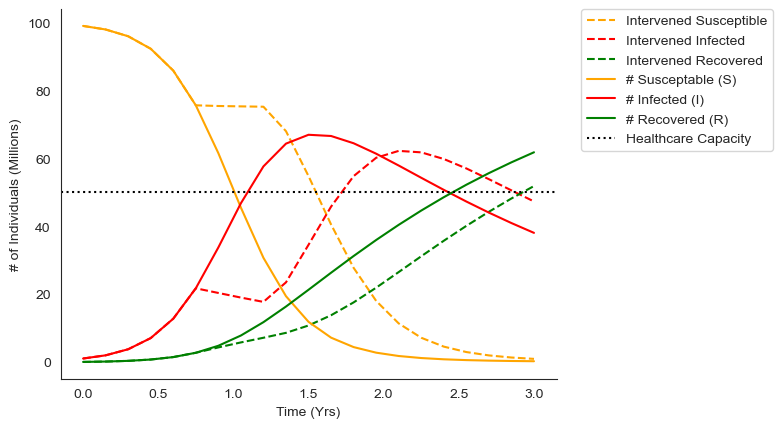

In [18]:
lockdown_policy = dict()
lockdown_policy[.751] = torch.tensor(.99) 
lockdown_policy[1.251] = torch.tensor(.0) # no more lockdowns

sir_intervene_traj = intervened_sir(lockdown_policy, init_state, time_period, beta_true=beta_true, gamma_true=gamma_true)

sns.lineplot(x=time_period, y=sir_intervene_traj.S, label='Intervened Susceptible', linestyle='--', color='orange')
sns.lineplot(x=time_period, y=sir_intervene_traj.I, label='Intervened Infected', linestyle='--', color='red')
sns.lineplot(x=time_period, y=sir_intervene_traj.R, label='Intervened Recovered', linestyle='--', color='green')

sns.lineplot(x=time_period, y=sir_true_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_true_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_true_traj.R, label="# Recovered (R)", color='green')
plt.axhline(50, label='Healthcare Capacity', color='black', linestyle='dotted')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Next, let's consider a state-dependent intervention ("dynamic intervention")

### Here we assume that the government will issue a lockdown measure that reduces the transmission rate by one half whenever the number of infected people hits 10 million

In [19]:
def government_lockdown_policy(target_state: State[torch.tensor]):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        # ret = target_state.subtract_shared_variables(state).l2()
        return state.I - target_state.I
    return event_f


def government_lift_policy(target_state: State[torch.tensor]):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        # ret = target_state.subtract_shared_variables(state).l2()
        return target_state.I - state.I
    return event_f


lockdown_trigger = State(I=torch.tensor(10.))
lockdown_strength = State(l=torch.tensor(.5)) # reduces transmission rate by 50%

In [20]:
with SimulatorEventLoop():
    with DynamicIntervention(
        event_f=government_lockdown_policy(lockdown_trigger),
        intervention=lockdown_strength,
        var_order=init_state.var_order,
        max_applications=1,
    ):
        sir_intervene_traj = simulate(SimpleSIRDynamicsIntervenable(beta_true, gamma_true), 
                                      init_state, time_period)


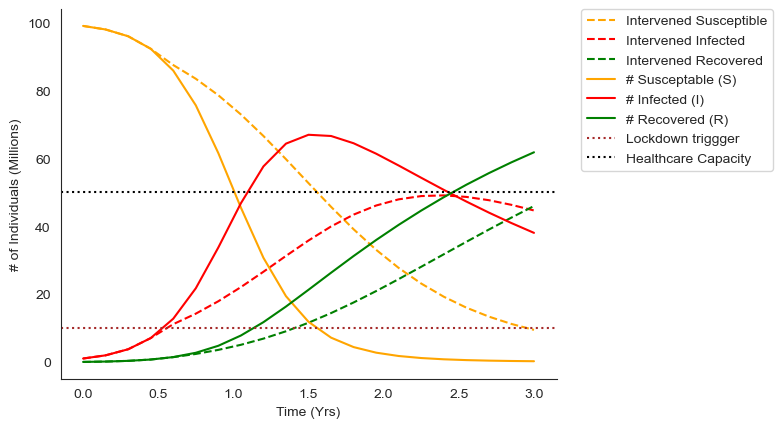

In [21]:
sns.lineplot(x=time_period, y=sir_intervene_traj.S, label='Intervened Susceptible', linestyle='--', color='orange')
sns.lineplot(x=time_period, y=sir_intervene_traj.I, label='Intervened Infected', linestyle='--', color='red')
sns.lineplot(x=time_period, y=sir_intervene_traj.R, label='Intervened Recovered', linestyle='--', color='green')

sns.lineplot(x=time_period, y=sir_true_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_true_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_true_traj.R, label="# Recovered (R)", color='green')
plt.axhline(10, label='Lockdown triggger', color='brown', linestyle='dotted')
plt.axhline(50, label='Healthcare Capacity', color='black', linestyle='dotted')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# 

# Multilevel SIR Model

So far we have assumed we only observe data from one region. Now let's imagine we observe data from $M$ different regions. For region $m$, $1 \leq m \leq M$, we observe a set of features $x_m \in \mathbb{R}^2$ that influence both the transmission rate ($\beta_m$) and recovery rate ($\gamma_m$). Specifically,

$$\beta_m \sim f_{\beta}(x_m) + \mathrm{HalfNormal}(.01), \quad \gamma_m \sim f_{\gamma}(x_m) + \mathrm{HalfNormal}(.1),$$

where $f_{\beta}$ and $f_{\gamma}$ are unknown functions. Since $f_{\beta}$ and $f_{\gamma}$ are shared across all $M$ regions, we use Bayesian Hierarchical modeling to better estimate the SIR parameters.

Note: we assume there are no interactions between regions (i.e., individuals from one region cannot infect those from another)

In [123]:
class SimpleSIRDynamicsIntervenableNamed(SimpleSIRDynamicsIntervenable):
    def __init__(self, beta0, gamma, name):
        super().__init__(beta0, gamma)
        self.name = name

    def observation(self, X: State[torch.Tensor]):
        test_kit_sales = torch.relu(pyro.sample(f"test_kit_sales_{self.name}", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample(f"I_obs_{self.name}", dist.Poisson(X.I))
        R_obs = pyro.sample(f"R_obs_{self.name}", dist.Poisson(X.R))
        return {f"test_kit_sales_{self.name}": test_kit_sales, f"I_obs_{self.name}": I_obs, f"R_obs_{self.name}": R_obs}


# def unit_level_sir(f_beta, f_gamma, x, unit_name):
#     beta0_noise = pyro.sample(f"beta0_noise_{unit_name}", dist.HalfNormal(.01))
#     beta0 = pyro.deterministic(f"beta0_{unit_name}", f_beta(x) + beta0_noise)
#     gamma_noise = pyro.sample(f"gamma_noise_{unit_name}", dist.HalfNormal(.1))
#     gamma = pyro.deterministic(f"gamma_{unit_name}", f_gamma(x) + gamma_noise)
#     sir = SimpleSIRDynamicsIntervenableNamed(beta0, gamma, unit_name)
#     return sir, beta0, gamma

def unit_level_sir(f_beta, f_gamma, x, unit_name):
    beta0 = pyro.sample(f"beta0_{unit_name}", dist.Uniform(0.05, 0.5))
    gamma = pyro.sample(f"gamma_{unit_name}", dist.Uniform(0.1, 1.))
    sir = SimpleSIRDynamicsIntervenableNamed(beta0, gamma, unit_name)
    return sir, beta0, gamma


def multi_level_sir(X):
    # X - matrix where row is a unit and columns are demographic features
    p = X.shape[1]
    # f_beta = pyro.nn.DenseNN(p, [10, 10], [1]) # 2 layer NN
    # f_gamma = pyro.nn.DenseNN(p, [10, 10], [1]) # 2 layer NN
    f_beta_params = pyro.sample("f_beta_params", dist.HalfNormal(.1).expand([p]).to_event(1))
    f_gamma_params = pyro.sample("f_gamma_params", dist.HalfNormal(.1).expand([p]).to_event(1))
    f_beta = lambda x: x @ f_beta_params
    f_gamma = lambda x: x @ f_gamma_params
    all_unit_sir = []
    for unit_ix, xi in enumerate(X):
        sir, __, __ = unit_level_sir(f_beta, f_gamma, xi, unit_ix)
        all_unit_sir.append(sir)
    return all_unit_sir

def unconditioned_multi_level_sir(X, init_states, tspan):
    all_unit_sir = multi_level_sir(X)
    solutions = []
    for unit_ix, _ in enumerate(X):
        sir = all_unit_sir[unit_ix]
        init_state = init_states[unit_ix]
        with SimulatorEventLoop():
            solution = simulate(sir, init_state, tspan)
        solutions.append(solution)
        [pyro.deterministic(f"{k}_{unit_ix}", getattr(solution,k)) for k in solution.keys]
    
    return solutions


def conditioned_multi_level_sir(X, multi_data, init_states, tspan):
    all_unit_sir = multi_level_sir(X)
    solutions = []
    for unit_ix, data in multi_data.items():
        sir = all_unit_sir[unit_ix]
        init_state = init_states[unit_ix]
        with SimulatorEventLoop():
            with TrajectoryObservation(data):
                solution = simulate(sir, init_state, tspan)
        solutions.append(solution)
        [pyro.deterministic(f"{k}_{unit_ix}", getattr(solution,k)) for k in solution.keys]

    return solutions

In [124]:
obs_time_period = torch.arange(1/52, .51, 1/52) # collect data
N_obs = obs_time_period.shape[0]

N_stratum = 5
N_covariates = 2

X = dist.HalfNormal(1).sample((N_stratum, N_covariates))
f_beta_true = lambda x: math.sqrt(.025) * x[0]
f_gamma_true = lambda x: math.sqrt(.1) * x[0]
multi_data = {}
init_states = []
all_unit_beta_true = []
all_unit_gamma_true = []
# beta0_grid = torch.tensor([.025, .05, .1, .15, .20])
# gamma_grid = torch.tensor([.5, .5, .5, .5, .5])
for unit_ix, xi in enumerate(X):
    # beta0 = beta0_grid[unit_ix]
    # gamma = gamma_grid[unit_ix]
    # sir = SimpleSIRDynamicsIntervenableNamed(beta0, gamma, unit_ix)
    sir, beta0, gamma = unit_level_sir(f_beta_true, f_gamma_true, xi, unit_ix)
    all_unit_beta_true.append(beta0.item())
    all_unit_gamma_true.append(gamma.item())
    init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.), l=torch.tensor(0.))
    sir_traj = simulate(sir, init_state, obs_time_period)

    data = dict()
    for time_ix in range(N_obs):
        data[obs_time_period[time_ix].item()] = sir.observation(sir_traj[time_ix])
    multi_data[unit_ix] = data
    # multi_data[unit_ix] = unit_data
    init_states.append(init_state)

In [158]:
multi_guide = AutoMultivariateNormal(conditioned_multi_level_sir)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(conditioned_multi_level_sir, multi_guide, adam, loss=Trace_ELBO())
n_steps = 2

# Do gradient steps
pyro.clear_param_store()
for step in range(n_steps):
    loss = svi.step(X, multi_data, init_states, torch.tensor([0., 3.])) # need tspan to contain all observation times
    print("[iteration %04d] loss: %.4f" % (step + 1, loss / N_obs))

[iteration 0001] loss: 105.9819
[iteration 0002] loss: 102.0228


In [161]:
# Generate samples from the posterior predictive distribution
predictive = Predictive(unconditioned_multi_level_sir, guide=multi_guide, num_samples=5)
samples = predictive(X, init_states, time_period)

In [164]:
samples['R_0'].shape

torch.Size([5, 21])

In [ ]:
SIR_plot(time_period, 0.5, S_pred, sir_true_traj.S, "Predicted # Susceptible (Millions)", "orange", "Actual # Susceptible", ax[0])

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


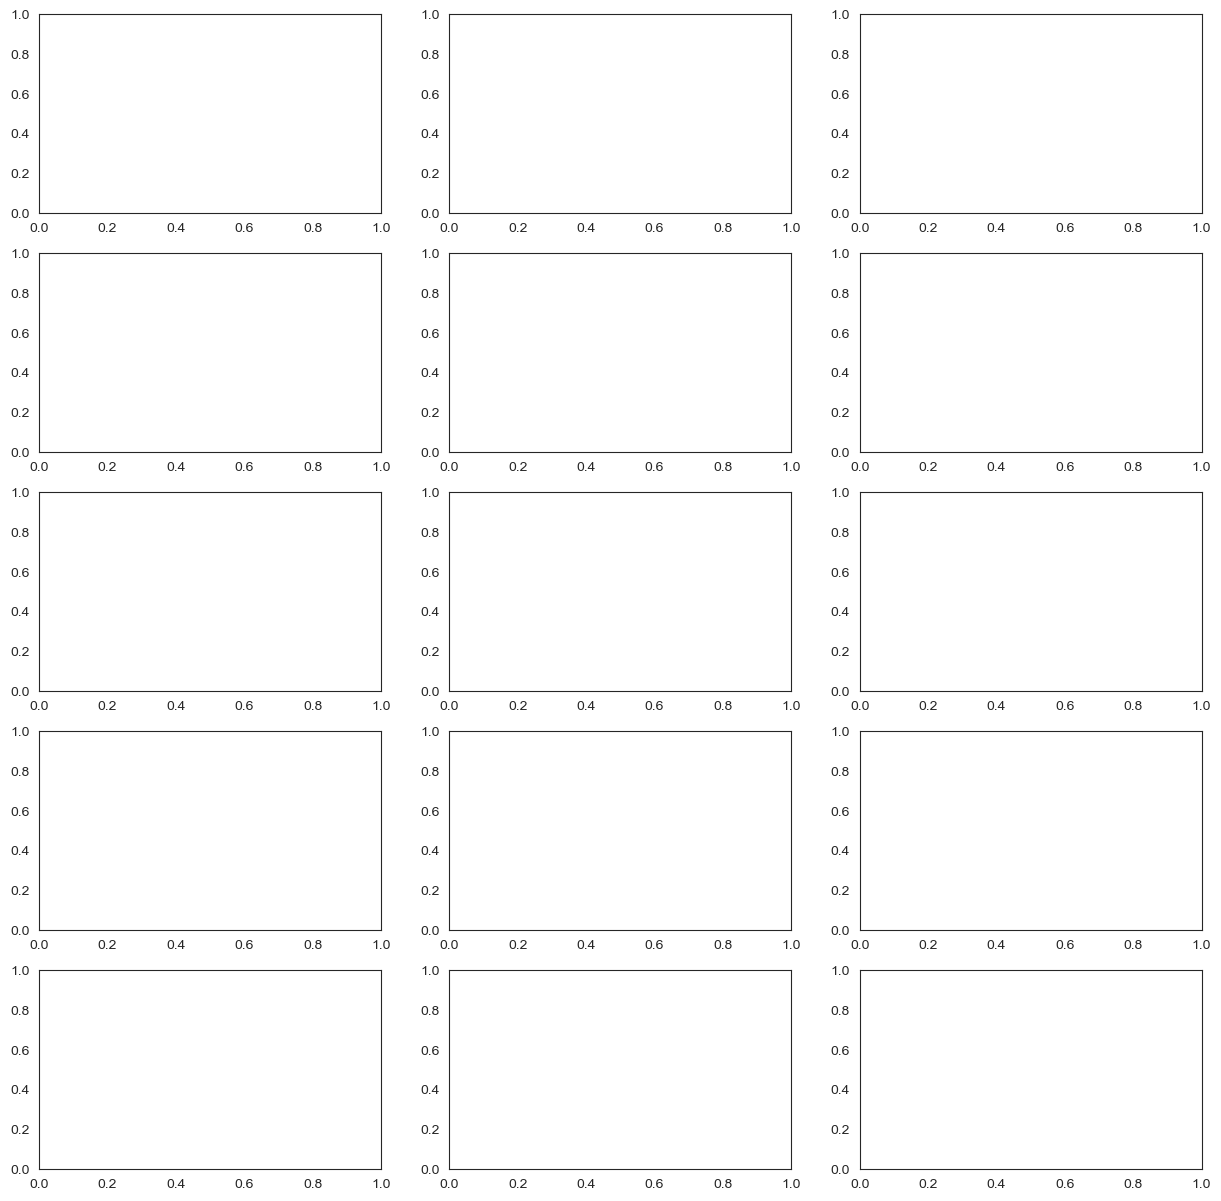

In [166]:
# Plot predicted values for S, I, and R with uncertainty bands (+/- 2 std. devs.)

fig, ax = plt.subplots(N_stratum, 3, figsize=(15, 15))

states = ["S", "I", "R"]
colors = ["orange", "red", "green"]
pred_labels = ["Predicted # Susceptible (Millions)", "Predicted # Infected (Millions)", "Predicted # Recovered (Millions)"]
data_labels = ["Actual # Susceptible", "Actual # Infected", "Actual # Recovered"]


for i in range(N_stratum):
    for j, (state, color, pred_label, data_label) in enumerate(zip(states, colors, pred_labels, data_labels)):
        SIR_plot(time_period, 0.5, samples[f"{state}_{i}"], data, pred_label, color, data_label, ax[i, j])


In [83]:
all_unit_beta_true

[0.05693013593554497]

In [111]:
samples['f_beta_params']

tensor([[0.2359, 0.0493],
        [0.0307, 0.0646],
        [0.0376, 0.0255],
        [0.0605, 0.0657],
        [0.0634, 0.0394],
        [0.0548, 0.0768],
        [0.1702, 0.0817],
        [0.0700, 0.1323],
        [0.0450, 0.0479],
        [0.0276, 0.0644],
        [0.0454, 0.0691],
        [0.0725, 0.0409],
        [0.0376, 0.0456],
        [0.0813, 0.1124],
        [0.0258, 0.0398],
        [0.0395, 0.0222],
        [0.0350, 0.0226],
        [0.0432, 0.0326],
        [0.0287, 0.0554],
        [0.0400, 0.1029],
        [0.0347, 0.0242],
        [0.0286, 0.0379],
        [0.0803, 0.0234],
        [0.0692, 0.0663],
        [0.0493, 0.0228],
        [0.0202, 0.0406],
        [0.0528, 0.0553],
        [0.1551, 0.0455],
        [0.0785, 0.0289],
        [0.0093, 0.0428],
        [0.0469, 0.0528],
        [0.0375, 0.0480],
        [0.0326, 0.1076],
        [0.0042, 0.0437],
        [0.0171, 0.0341],
        [0.0762, 0.0285],
        [0.0521, 0.0969],
        [0.0388, 0.0491],
        [0.0

In [76]:
(samples['f_beta_params'] @ X.T).mean(axis=0)

tensor([0.1448])

In [74]:
samples['beta0_noise_0']

tensor([0.0040, 0.0042, 0.0072, 0.0074, 0.0035, 0.0032, 0.0108, 0.0063, 0.0022,
        0.0023, 0.0075, 0.0044, 0.0020, 0.0023, 0.0052, 0.0042, 0.0053, 0.0038,
        0.0022, 0.0060, 0.0084, 0.0055, 0.0036, 0.0080, 0.0016, 0.0046, 0.0022,
        0.0015, 0.0179, 0.0094, 0.0081, 0.0075, 0.0059, 0.0105, 0.0066, 0.0058,
        0.0061, 0.0036, 0.0065, 0.0034, 0.0031, 0.0015, 0.0033, 0.0044, 0.0037,
        0.0180, 0.0059, 0.0048, 0.0040, 0.0024, 0.0083, 0.0091, 0.0122, 0.0037,
        0.0020, 0.0045, 0.0029, 0.0081, 0.0037, 0.0051, 0.0174, 0.0040, 0.0032,
        0.0018, 0.0087, 0.0057, 0.0006, 0.0051, 0.0064, 0.0101, 0.0050, 0.0013,
        0.0057, 0.0035, 0.0045, 0.0034, 0.0042, 0.0074, 0.0044, 0.0048, 0.0030,
        0.0009, 0.0065, 0.0144, 0.0070, 0.0080, 0.0015, 0.0023, 0.0016, 0.0023,
        0.0045, 0.0051, 0.0009, 0.0135, 0.0026, 0.0014, 0.0040, 0.0015, 0.0033,
        0.0066])

In [77]:
# (torch.abs(samples['beta_params'] * X[0, :]).sum(axis=1) + samples['beta0_noise_0']).mean()

In [67]:
pyro.render_model(multi_level_conditioned_sir, model_args=(X, multi_data, init_states, time_period))

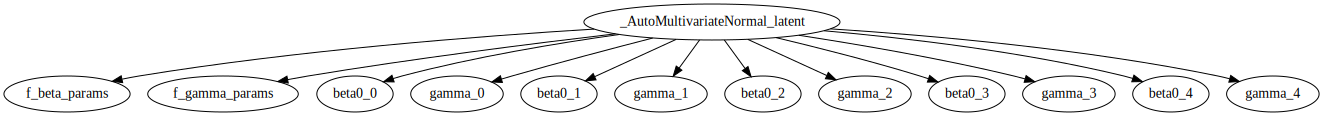

In [66]:
pyro.render_model(multi_guide, model_args=(X, multi_data, init_states, time_period))

# References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan
2. https://benjaminmoll.com/wp-content/uploads/2020/05/SIR_notes.pdf